In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [3]:
data = pd.read_csv('./Data/H1B_2017.csv', low_memory=False)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 622773 entries, 0 to 622772
Data columns (total 13 columns):
Unnamed: 0              622773 non-null int64
employer                622773 non-null object
job_title               622773 non-null object
occupational_name       622773 non-null object
prevailing_wage         622773 non-null float64
pw_wage_period          622773 non-null object
employer_wage           622773 non-null float64
employer_max_wage       622773 non-null float64
employer_wage_period    622773 non-null object
city                    622773 non-null object
county                  622773 non-null object
state                   622773 non-null object
postal_code             622773 non-null object
dtypes: float64(3), int64(1), object(9)
memory usage: 61.8+ MB


In [5]:
data = data.drop('Unnamed: 0', axis=1)
data.head()

,employer,job_title,occupational_name,prevailing_wage,pw_wage_period,employer_wage,employer_max_wage,employer_wage_period,city,county,state,postal_code
0,DISCOVER PRODUCTS INC.,ASSOCIATE DATA INTEGRATION,COMPUTER SYSTEMS ANALYSTS,59197.0,Year,65811.0,67320.0,Year,RIVERWOODS,LAKE,IL,60015
1,DFS SERVICES LLC,SENIOR ASSOCIATE,OPERATIONS RESEARCH ANALYSTS,49800.0,Year,53000.0,57200.0,Year,RIVERWOODS,LAKE,IL,60015
2,INFO SERVICES LLC,PROJECT MANAGER,"COMPUTER OCCUPATIONS, ALL OTHER",90376.0,Year,102000.0,0.0,Year,JERSEY CITY,HUDSON,NJ,07302
3,BB&T CORPORATION,ASSOCIATE - ESOTERIC ASSET BACKED SECURITIES,CREDIT ANALYSTS,116605.0,Year,132500.0,0.0,Year,NEW YORK,NEW YORK,NY,10036
4,"SUNTRUST BANKS, INC.",CREDIT RISK METRICS SPECIALIST,"FINANCIAL SPECIALISTS, ALL OTHER",59405.0,Year,71750.0,0.0,Year,ATLANTA,FULTON,GA,30303


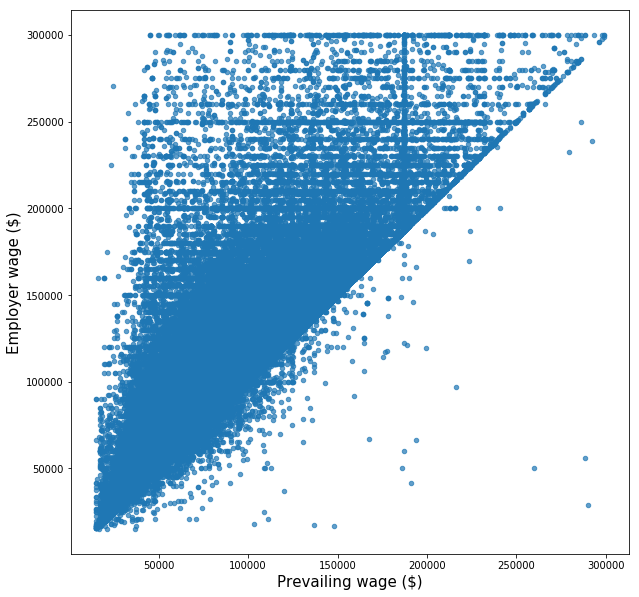

Pearson correlation: 0.8633


In [7]:
plt.figure(figsize=(10,10))
filter1 = (data.prevailing_wage<=300000) & (data.employer_wage<=300000)
plt.scatter(data.prevailing_wage[filter1], data.employer_wage[filter1], alpha=0.7, s=20)
plt.xlabel('Prevailing wage ($)', size=15)
plt.ylabel('Employer wage ($)', size=15)
plt.title('')
plt.show()

pearson = np.corrcoef(data.prevailing_wage[filter1], data.employer_wage[filter1])[0,1]
print("Pearson correlation: %.4f" %pearson)

In [8]:
print("Number of points for the whole data set: {}".format(len(data)))
print("Number of points for salaries: {}".format(len(data[filter1])))

Number of points for the whole data set: 622773
Number of points for salaries: 620729


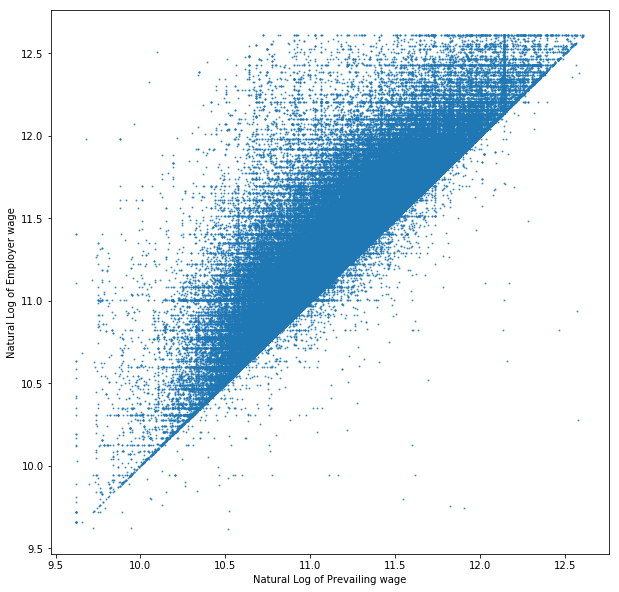

Pearson correlation: 0.8633


In [9]:
plt.figure(figsize=(10,10))
filter1 = (data.prevailing_wage<=300000) & (data.employer_wage<=300000)
plt.scatter(np.log(data.prevailing_wage[filter1]), \
            np.log(data.employer_wage[filter1]), alpha=0.7, s=1)
plt.xlabel('Natural Log of Prevailing wage')
plt.ylabel('Natural Log of Employer wage')
plt.show()

pearson = np.corrcoef(data.prevailing_wage[filter1], data.employer_wage[filter1])[0,1]
print("Pearson correlation: %.4f" %pearson)

In [10]:
# Selecting possible features to train model
columns = ['job_title', 'occupational_name', 'prevailing_wage', 'city', 'county', 'state', 'postal_code']
features = data[columns]
# Selecting possible targets
y_emp = data.employer_wage
y_pr = data.prevailing_wage

In [11]:
for col in columns:
    print("Number of unique values for column -{}- : {}".format(col, len(features[col].unique())))
print("Number of unique values for column -prevailing_wage- : {}".format(len(y_pr.unique())))
print("Number of unique values for column -employer_wage- : {}".format(len(y_emp.unique())))

Number of unique values for column -job_title- : 92756
Number of unique values for column -occupational_name- : 865
Number of unique values for column -prevailing_wage- : 24052
Number of unique values for column -city- : 7946
Number of unique values for column -county- : 3676
Number of unique values for column -state- : 57
Number of unique values for column -postal_code- : 12665
Number of unique values for column -prevailing_wage- : 24052
Number of unique values for column -employer_wage- : 50655


When a user wants to predict the employer's wage most likely he will not know the prevailing wage for his future position. To remediate this issue and make the model more robust, I propose to train part of the data to predict the prevailing wage and then use the rest of the data to predict the final salary.

The data points are selected randomly by index number in the data set.

In [12]:
indeces = np.arange(0, len(data))
# set seed for the rest of the project
seed = 14
np.random.seed(seed)
# shuffle indexes
random_index = np.random.permutation(indeces)

In [13]:
# Data for prevailing wage prediction
X_pr = features.iloc[random_index[:int(len(data)/2)]].reset_index(drop=True)
y_pr = np.log(y_pr.iloc[random_index[:int(len(data)/2)]]).reset_index(drop=True)
X_pr.drop(['prevailing_wage'], axis=1, inplace=True)

We intend to predict the prevailing wage using words, so per row the columns are merged into one preserving spaces between words and a vectorizer is created. Given the large amount of  data avalaibleb the proper model to use is an SDG Regressor but first we need to perform a cross-validation grid search to find the best parameters for the model.

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation


model = Sequential()
model.add(Dense(16, kernel_initializer='truncated_normal', activation='relu', input_shape=(23490,)))
model.add(Dense(32, kernel_initializer='truncated_normal', activation='relu', input_shape=(23490,)))
model.add(Dense(64, kernel_initializer='truncated_normal', activation='relu', input_shape=(23490,)))
model.add(Dense(1, activation=None))

model.summary()

/home/pfgr/anaconda3/envs/dl/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                375856    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 378,577
Trainable params: 378,577
Non-trainable params: 0
_________________________________________________________________


In [49]:
from keras.optimizers import Adam, SGD
optimizer = SGD(lr=0.05)
model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

In [41]:
from keras.wrappers.scikit_learn import KerasRegressor
from keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from time import time

# Merging columns per row
X_pr['merged'] = X_pr.job_title + " " + X_pr.occupational_name + " " + X_pr.city \
                    + " " + X_pr.county + " " + X_pr.state + " " + X_pr.postal_code
# Creating testing and training sets
X_train_pr, X_test_pr, y_train_pr, y_test_pr = \
                    train_test_split(X_pr.merged, y_pr, test_size=0.25, random_state=seed)

In [42]:
# Define pipeline steps
vect = CountVectorizer()
vect.fit(X_train_pr)
X_train_pr_vect = vect.transform(X_train_pr).tocsc()
X_test_pr_vect = vect.transform(X_test_pr).tocsc()

In [50]:
from keras.callbacks import ModelCheckpoint 

checkpointer = ModelCheckpoint(filepath='./Weights/weights.best.pr_wage.hdf5', verbose=1, 
                               save_best_only=True)
hist = model.fit(X_train_pr_vect, y_train_pr, epochs=100, batch_size=4096, \
          validation_data=(X_test_pr_vect, y_test_pr), callbacks=[checkpointer], verbose=2)

Train on 233539 samples, validate on 77847 samples
Epoch 1/100
 - 87s - loss: 5.1218 - mean_absolute_error: 0.9752 - val_loss: 0.1158 - val_mean_absolute_error: 0.2530

Epoch 00001: val_loss improved from inf to 0.11578, saving model to ./Weights/weights.best.pr_wage.hdf5
Epoch 2/100
 - 87s - loss: 0.1127 - mean_absolute_error: 0.2488 - val_loss: 0.1090 - val_mean_absolute_error: 0.2469

Epoch 00002: val_loss improved from 0.11578 to 0.10895, saving model to ./Weights/weights.best.pr_wage.hdf5
Epoch 3/100
 - 87s - loss: 0.1057 - mean_absolute_error: 0.2383 - val_loss: 0.1014 - val_mean_absolute_error: 0.2346

Epoch 00003: val_loss improved from 0.10895 to 0.10144, saving model to ./Weights/weights.best.pr_wage.hdf5
Epoch 4/100
 - 87s - loss: 0.0993 - mean_absolute_error: 0.2277 - val_loss: 0.0988 - val_mean_absolute_error: 0.2265

Epoch 00004: val_loss improved from 0.10144 to 0.09877, saving model to ./Weights/weights.best.pr_wage.hdf5
Epoch 5/100
 - 87s - loss: 0.1109 - mean_absolute

 - 87s - loss: 0.0881 - mean_absolute_error: 0.2222 - val_loss: 0.1041 - val_mean_absolute_error: 0.2504

Epoch 00046: val_loss did not improve from 0.06249
Epoch 47/100
 - 87s - loss: 0.0862 - mean_absolute_error: 0.2179 - val_loss: 0.0595 - val_mean_absolute_error: 0.1705

Epoch 00047: val_loss improved from 0.06249 to 0.05955, saving model to ./Weights/weights.best.pr_wage.hdf5
Epoch 48/100
 - 87s - loss: 0.0648 - mean_absolute_error: 0.1790 - val_loss: 0.0830 - val_mean_absolute_error: 0.2138

Epoch 00048: val_loss did not improve from 0.05955
Epoch 49/100
 - 87s - loss: 0.0857 - mean_absolute_error: 0.2185 - val_loss: 0.0710 - val_mean_absolute_error: 0.1913

Epoch 00049: val_loss did not improve from 0.05955
Epoch 50/100
 - 87s - loss: 0.0760 - mean_absolute_error: 0.2006 - val_loss: 0.0577 - val_mean_absolute_error: 0.1679

Epoch 00050: val_loss improved from 0.05955 to 0.05771, saving model to ./Weights/weights.best.pr_wage.hdf5
Epoch 51/100
 - 87s - loss: 0.0620 - mean_absolut


Epoch 00091: val_loss did not improve from 0.05331
Epoch 92/100
 - 87s - loss: 0.0669 - mean_absolute_error: 0.1854 - val_loss: 0.0530 - val_mean_absolute_error: 0.1601

Epoch 00092: val_loss improved from 0.05331 to 0.05298, saving model to ./Weights/weights.best.pr_wage.hdf5
Epoch 93/100
 - 87s - loss: 0.0560 - mean_absolute_error: 0.1637 - val_loss: 0.0529 - val_mean_absolute_error: 0.1599

Epoch 00093: val_loss improved from 0.05298 to 0.05288, saving model to ./Weights/weights.best.pr_wage.hdf5
Epoch 94/100
 - 87s - loss: 0.0546 - mean_absolute_error: 0.1609 - val_loss: 0.0534 - val_mean_absolute_error: 0.1604

Epoch 00094: val_loss did not improve from 0.05288
Epoch 95/100
 - 88s - loss: 0.0555 - mean_absolute_error: 0.1626 - val_loss: 0.0571 - val_mean_absolute_error: 0.1701

Epoch 00095: val_loss did not improve from 0.05288
Epoch 96/100
 - 87s - loss: 0.0578 - mean_absolute_error: 0.1675 - val_loss: 0.0868 - val_mean_absolute_error: 0.2291

Epoch 00096: val_loss did not impro

In [15]:
# Load weights giving the best validation accuracy
model.load_weights('./Weights/weights.best.pr_wage.hdf5')

In [64]:
# Evaluate and print test accuracy
score = model.evaluate(X_test_pr_vect, y_test_pr, verbose=0)
print('Mean absolute error: %.4f' % score[1])

Mean absolute error: 0.1591


In [62]:
# Predict real values by eliminating natural log
X_test_pr_pred = np.exp(model.predict(X_test_pr_vect))
# Eliminate natural log from target
y_test_pr_real = np.exp(y_test_pr)

In [63]:
# Calculate mean absolute error
error = mean_absolute_error(X_test_pr_pred, y_test_pr_real)
print('Mean absolute error in non-log test predictions: %.2f' % error)

Mean absolute error in non-log test predictions: 32619.12


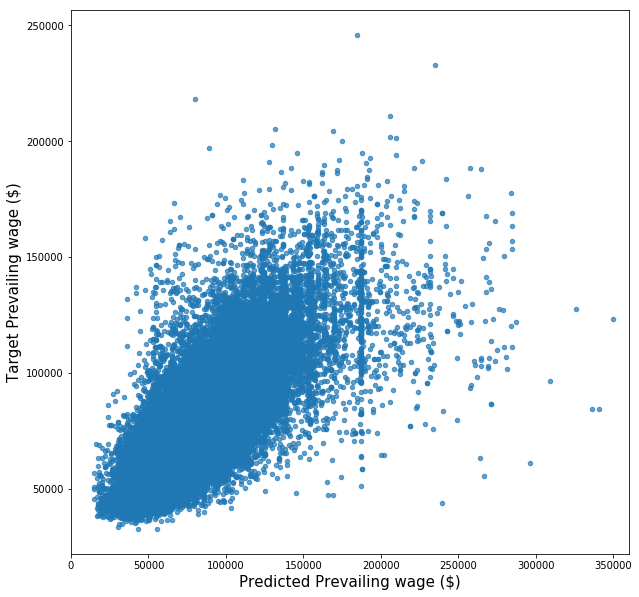

Pearson correlation: 0.0062


In [96]:
plt.figure(figsize=(10,10))
filter1 = (data.prevailing_wage<=300000) & (data.employer_wage<=300000)
plt.scatter(y_test_pr_real, X_test_pr_pred, alpha=0.7, s=20)
plt.xlabel('Predicted Prevailing wage ($)', size=15)
plt.xlim(0, 360000)
plt.ylabel('Target Prevailing wage ($)', size=15)
#plt.ylim(0, 300000)
plt.title('')
plt.show()

# pearson = np.corrcoef(y_test_pr_real, X_test_pr_pred[:,0])[0,1]
# print("Pearson correlation: %.4f" %pearson)

Now we use the other half of the data to predict salary wage by two methods and compare them. First, we predict the employer's wage using the state, the postal_code and the prevailing_wage from the data set. 

The second method consists on training the model with the same features but instead of using the prevailing wage from the data, we used instead the predicted one from the model just trained above.

Let's get first the second half of the data from the original dataset.

In [17]:
# Data for employer wage prediction
X_em = features.iloc[random_index[int(len(data)/2)]:].reset_index(drop=True)
X_em.prevailing_wage = np.log(X_em.prevailing_wage)
X_em_full = X_em.copy()
X_em.drop(['job_title', 'occupational_name', 'city', 'county'], axis=1, inplace=True)
# Employer wage
y_em = np.log(y_emp.iloc[random_index[int(len(data)/2)]:].reset_index(drop=True))

In [18]:
X_em.head()

,prevailing_wage,state,postal_code
0,10.931499,NJ,07306
1,11.069914,UT,84111
2,11.260997,NJ,08534
3,11.359774,OH,44321
4,10.994572,VA,23230


The amount of data being significant, first we define a function having the purpose of creating batches for batch training.

In [19]:
def batches(size, X, y):
    # This function transform data to be trained into batches
    batch_start = 0
    n_points = X.shape[0]
    while batch_start < n_points:
        batch_end = batch_start + size
#         X_batch = pd.get_dummies(X.iloc[range(batch_start, batch_end)], \
#                                  columns=['postal_code','state'], drop_first=True)
        if batch_end < n_points:
            X_batch = X.iloc[range(batch_start, batch_end)]
            y_batch = y.iloc[range(batch_start, batch_end)]
        else:
            X_batch = X.iloc[range(batch_start,n_points)]
            y_batch = y.iloc[range(batch_start, n_points)]
        yield X_batch, y_batch
        batch_start += size
        
        #permutation with np.random.permutation in indexes

First let's predict employer wages with prevailing wage from data set. For this part, the state and postal_code columns being of categorical type, it is necessary to use one-hot encoding.

In [20]:
from dummyPy import OneHotEncoder

# Create one-hot encoder and fit it to the data
encoder = OneHotEncoder(['postal_code', 'state'])
encoder.fit(X_em)

In [22]:
# Creating training and test sets
X_train_em, X_test_em, y_train_em, y_test_em = train_test_split(X_em, y_em, test_size=0.25, random_state=seed)

In [23]:
# Set parameters for batch training
batch_size = 20000
# Get batches
train_batches = batches(batch_size, X_train_em, y_train_em)

In [117]:
# # Define pipeline steps
# steps = [('encoder', encoder),
#          ('wage_reg1', SGDRegressor(penalty='l2',max_iter=200, random_state=seed))]
# # Define pipeline
# pipeline = Pipeline(steps)

In [119]:
# # Start training
# start = time() #start time
# for X_batch, y_batch in train_batches:
#     #X_batch_trans = encoder.transform(X_batch)
#     pipeline.partial_fit(X_batch_trans, y_batch)
# end = time() #end time

In [27]:
regressor_wage = SGDRegressor(random_state=seed, max_iter=400)

# Start training
start = time() #start time
for X_batch, y_batch in train_batches:
    X_batch_trans = encoder.transform(X_batch)
    regressor_wage.partial_fit(X_batch_trans, y_batch)
end = time() #end time

regressor_name = regressor_wage.__class__.__name__
print("%s training time: %.3fs" %(regressor_name, end-start))

SGDRegressor training time: 590.469s


In [30]:
# Prediction on test set
test_batches = batches(batch_size, X_test_em, y_test_em)
y_pred_wage = []
for X_tbatch, y_tbatch in test_batches:
    X_test_trans = encoder.transform(X_tbatch)
    y_pred_wage.extend(regressor_wage.predict(X_test_trans))

In [33]:
# Calculate mean absolute error
mean_error = mean_absolute_error(y_pred_wage, y_test_em)
print("{} mean absolute error: {:.4f}".format(regressor_name, mean_error))

SGDRegressor mean absolute error: 0.1150


In [34]:
# Calculate mean absolute error non log
y_pred_wage_real = np.exp(y_pred_wage)
y_test_real = np.exp(y_test_em)
mean_error_real = mean_absolute_error(y_pred_wage_real, y_test_real)
print("{} real mean absolute error: {:.2f}".format(regressor_name, mean_error_real))

SGDRegressor real mean absolute error: 43986.84


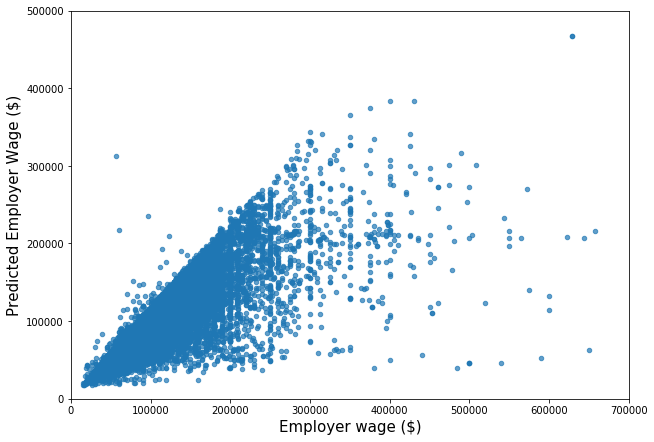

In [35]:
plt.figure(figsize=(10,7.143))
plt.scatter(y_test_real, y_pred_wage_real, alpha=0.7, s=20)
plt.xlabel('Employer wage ($)', size=15)
plt.xlim(0, 700000)
plt.ylabel('Predicted Employer Wage ($)', size=15)
plt.ylim(0, 500000)
plt.show()

Now let's predict prevailing wage from word model.

In [37]:
# Merged categotical columns per row
X_em_full['merged'] = X_em_full.job_title + " " + X_em_full.occupational_name + " " \
                        + X_em_full.city + " " + X_em_full.county + " " + X_em_full.state \
                        + " " + X_em_full.postal_code

In [43]:
# Predict prevailing wage and add to X_em
X_em['pred_prevailing_wage'] = model.predict(vect.transform(X_em_full.merged).tocsc())
X_em.head()

,prevailing_wage,state,postal_code,pred_prevailing_wage
0,10.931499,NJ,07306,11.020419
1,11.069914,UT,84111,10.870985
2,11.260997,NJ,08534,11.044121
3,11.359774,OH,44321,11.196577
4,10.994572,VA,23230,11.216660


In [44]:
# Define train and test set
use_columns = ['pred_prevailing_wage', 'state', 'postal_code']
X_train, X_test, y_train, y_test = train_test_split(X_em[use_columns], y_em, test_size=0.25, random_state=seed)

# Get batches
train_batches = batches(batch_size, X_train, y_train)

In [45]:
# Initialize regressor
regressor_wage_pred_pr = SGDRegressor(random_state=seed, max_iter=400)
# Start training
start = time() #start time
for X_batch, y_batch in train_batches:
    X_batch_trans = encoder.transform(X_batch)
    regressor_wage_pred_pr.partial_fit(X_batch_trans, y_batch)
end = time() #end time

regressor_name = regressor_wage.__class__.__name__
print("%s training time: %.3fs" %(regressor_name, end-start))

SGDRegressor training time: 539.931s


In [46]:
# Predict on test set
test_batches = batches(batch_size, X_test, y_test)
y_pred_wage_pred_pr = []
for X_tbatch, y_tbatch in test_batches:
    X_test_trans = encoder.transform(X_tbatch)
    y_pred_wage_pred_pr.extend(regressor_wage.predict(X_test_trans))

In [47]:
# Calculate mean absolute error
mean_error = mean_absolute_error(y_pred_wage_pred_pr, y_test)
print("{} mean absolute error: {:.4f}".format(regressor_name, mean_error))

SGDRegressor mean absolute error: 0.1796


In [48]:
real_pred_wage = np.exp(y_pred_wage_pred_pr)
real_wage = np.exp(y_test)
real_mean_error = mean_absolute_error(real_pred_wage, real_wage)
print("{} real mean absolute error: {:.2f}".format(regressor_name, real_mean_error))

SGDRegressor real mean absolute error: 30678.08


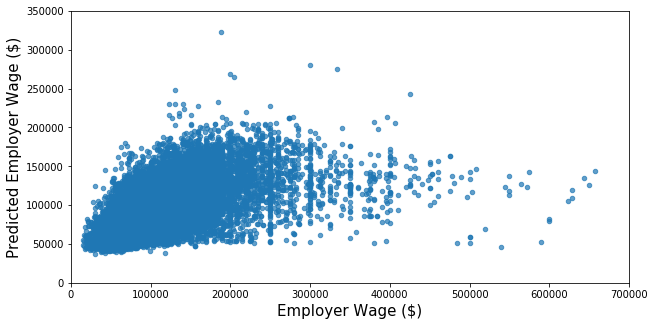

In [49]:
plt.figure(figsize=(10,5))
plt.scatter(real_wage, real_pred_wage, alpha=0.7, s=20)
plt.xlabel('Employer Wage ($)', size=15)
plt.xlim(0, 700000)
plt.ylabel('Predicted Employer Wage ($)', size=15)
plt.ylim(0, 350000)
plt.show()